In [6]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np
from tqdm import tqdm
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
def get_rec(rn):
    return np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item()

## 1. Slices

In [3]:
def plot_silces_multi_runs(
        r_s, i_s, k,
        plot_log=True, save_fn=None, titles=None,
        shift_mean=None, plot_delta=False, individual_cbar=False,
        plot_change_i_s=None,
    ):

    if isinstance(i_s, int):
        i_s = np.full(len(r_s), i_s)

    plot_n = len(r_s)
    if plot_delta:
        plot_n += 1

    fig, axs = plt.subplots(1, plot_n, figsize=(6*plot_n, 7))
    if plot_n == 1:
        axs = [axs]

    if plot_change_i_s is not None:
        z_s = [r[k][i] - r[k][i-c_i] for i, r, c_i in zip(i_s, r_s, plot_change_i_s)]
    else:
        z_s = [r[k][i] for i, r in zip(i_s, r_s)]
    if k == 'x_H_slice':
        z_s = [1-z for z in z_s]
    z_mean_s = [np.mean(z) for z in z_s]
    if shift_mean is not None:
        if shift_mean == '+':
            z_s = [z-z_mean_s[i_plot] for i_plot, z in enumerate(z_s)]
        else:
            z_s = [z/z_mean_s[i_plot] for i_plot, z in enumerate(z_s)]
    if plot_log:
        z_s = [np.log10(z) for z in z_s]
    vmin = np.quantile(np.concatenate(z_s), 0.02)
    vmax = np.quantile(np.concatenate(z_s), 0.98)

    for i_plot in range(len(r_s)):
        ax = axs[i_plot]
        if individual_cbar:
            im = ax.imshow(z_s[i_plot], origin='lower')
            fig.colorbar(im, ax=ax, orientation='horizontal')
        else:
            im = ax.imshow(z_s[i_plot], origin='lower', vmin=vmin, vmax=vmax)
        title = titles[i_plot] if titles is not None else ''
        ax.set_title(f"{title} mean={z_mean_s[i_plot]:.3e}")

    k_title = k if k != 'x_H_slice' else '1-x_H_slice'
    if plot_change_i_s is not None:
        k_title = r"$\Delta$" + k_title
    fig.suptitle(f"{k_title}, $z$={r_s[0]['z'][i_s[0]]:.3f}")
    if not individual_cbar:
        fig.colorbar(im, ax=axs[:len(r_s)], orientation='horizontal', aspect=len(r_s)*20)
    if plot_delta:
        ax = axs[-1]
        im_delta = ax.imshow(r_s[0]['delta_slice'][i_s[0]], origin='lower', cmap='viridis')
        ax.set_title('delta')
        fig.colorbar(im_delta, ax=axs[-1], orientation='horizontal', aspect=20)

    if save_fn is not None:
        fig.savefig(save_fn)
        plt.close(fig)

In [13]:
run_names = [
    # 'sf_xunifx100_nodplus1_nopop2',
    # 'sf_xunifx100_nodplus1_dc_noLX_nopop2_uddn',
    # 'sf_xdecayx100_nodplus1_nopop2',
    # 'sf_xdecayx100_nodplus1_nopop2_uddn_test',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_01atten',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots',
    # 'sf_xdecayx100_dc_noLX_nodplus1_nopop2_uddn_xrayots_cut500',
    
    # 'sf_xdecayx100_nodplus1_nopop2_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_zf001_Rmax32',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xrayots_cut500_zf001',
    # 'sf_xdecayx100_nodplus1_dc_noLX_nopop2_uddn_xraybath_cut500_zf001',
    
    # 'sf_xdecayx10_nodplus1_noxesink_nopop2_zf001',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots_zf001',

    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots', # just to make sure I understand bath
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots',

    #--- All dep to ion ---
    # 'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001',
    #'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001_fix',

    #--- All dep to ion zf01 ---
    # 'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath32_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath64_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath128_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_bath500_ots',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell15',
    # 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell15_fix',

    # 'stepinit_xdecay',
    # 'stepinit_dc_xdecay',
    # 'stepinit_dc_xdecay_noOTS',
    # 'stepinit_xdecay_zf001',
    # 'stepinit_dc_xdecay_ion_zf001',

    # 'xdecay', # done
    # 'xdecay_zf001', # done
    # 'fc_xray_32_zf0005_sf40',
    # 'xdecay_dc_zf001', # this is just same as _scf1
    # 'xdecay_dc_zf002',
    # 'xdecay_dc_zf005',

    #'xdecay_dc_zf001_scf1', # done
    #'xdecay_dc_zf001_scf10', # done
    #'xdecay_dc_zf001_scf10_subdelta', # not doing
    #'xdecay_dc', # rerun

    'fc_xray_128_LX',
    'fc_xray_128_zf0005_sf40',
    'fc_xray_128_zf001_sf20',
    'fc_xray_128_zf002_sf10',

    # 'fc_xray_128_LX_xesink',
    # 'fc_xray_128_zf001_sf20_xesink',
    # 'fc_xray_128_zf002_sf10',
]
r_s = [np.load(f"../outputs/dm21cm/{rn}_records.npy", allow_pickle=True).item() for rn in run_names]
#titles = ['21cmFAST zf01', '21cmFAST zf001', 'DM21cm zf001', 'DM21cm zf001-01', 'DM21cm zf01']
titles = run_names

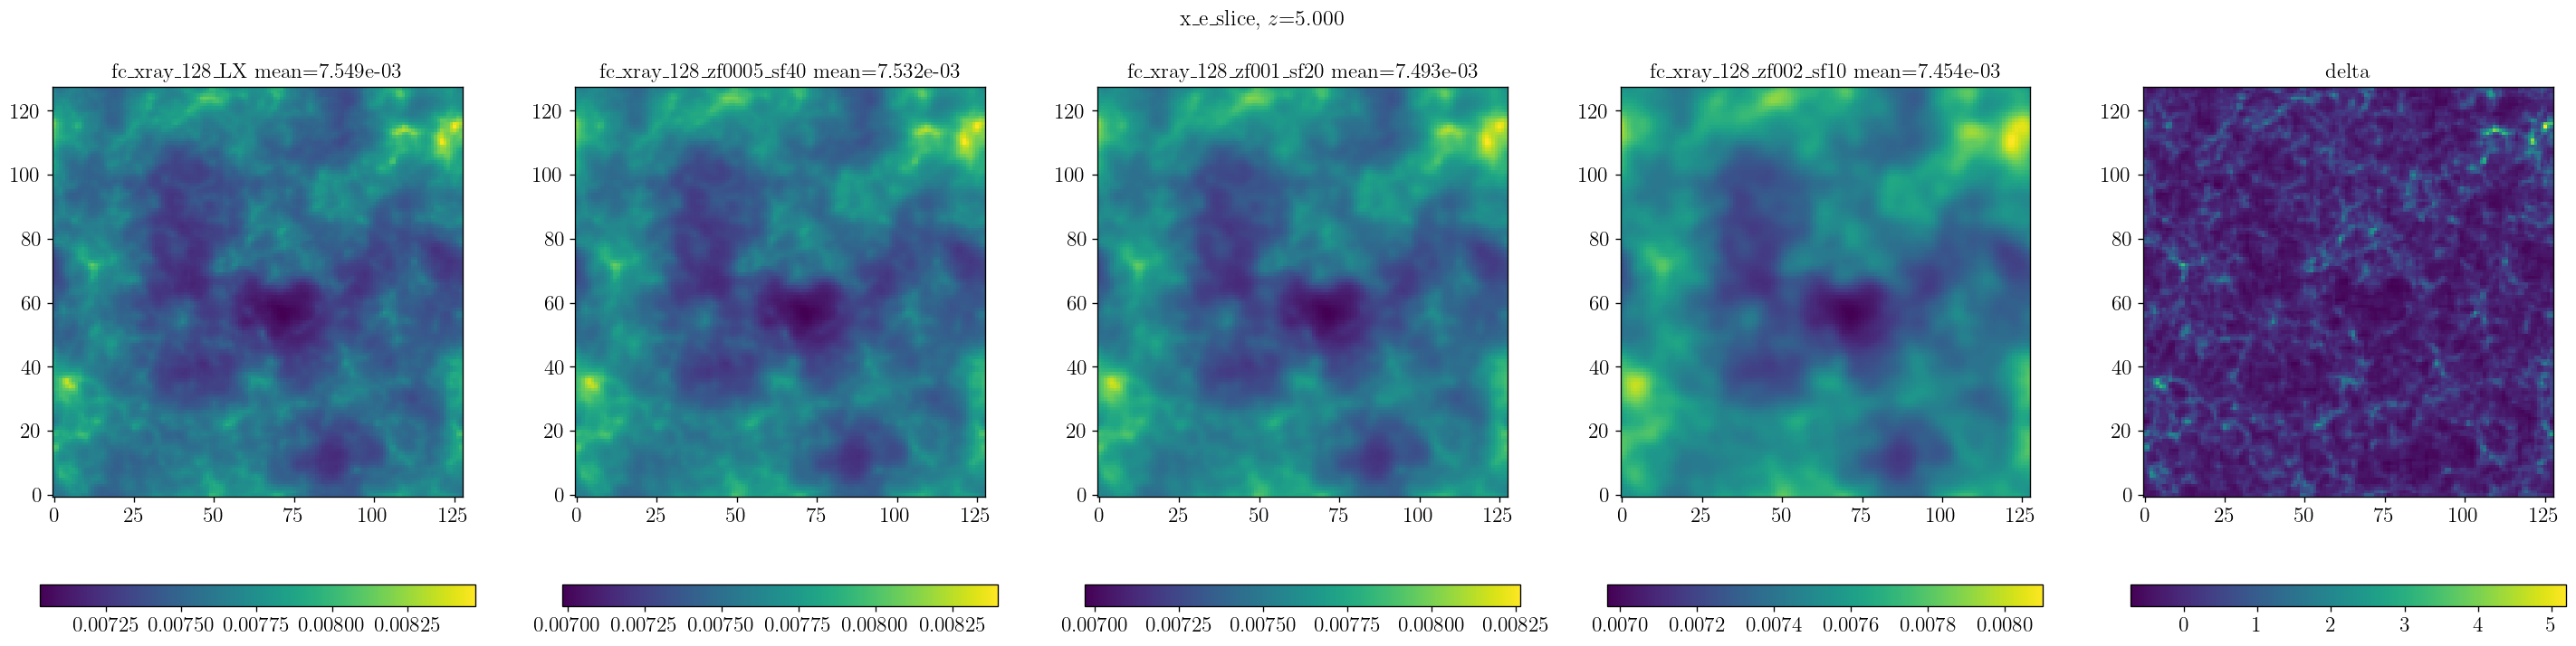

In [14]:
plot_silces_multi_runs(r_s, -1, 'x_e_slice', titles=titles, plot_delta=True, plot_log=False, individual_cbar=True)

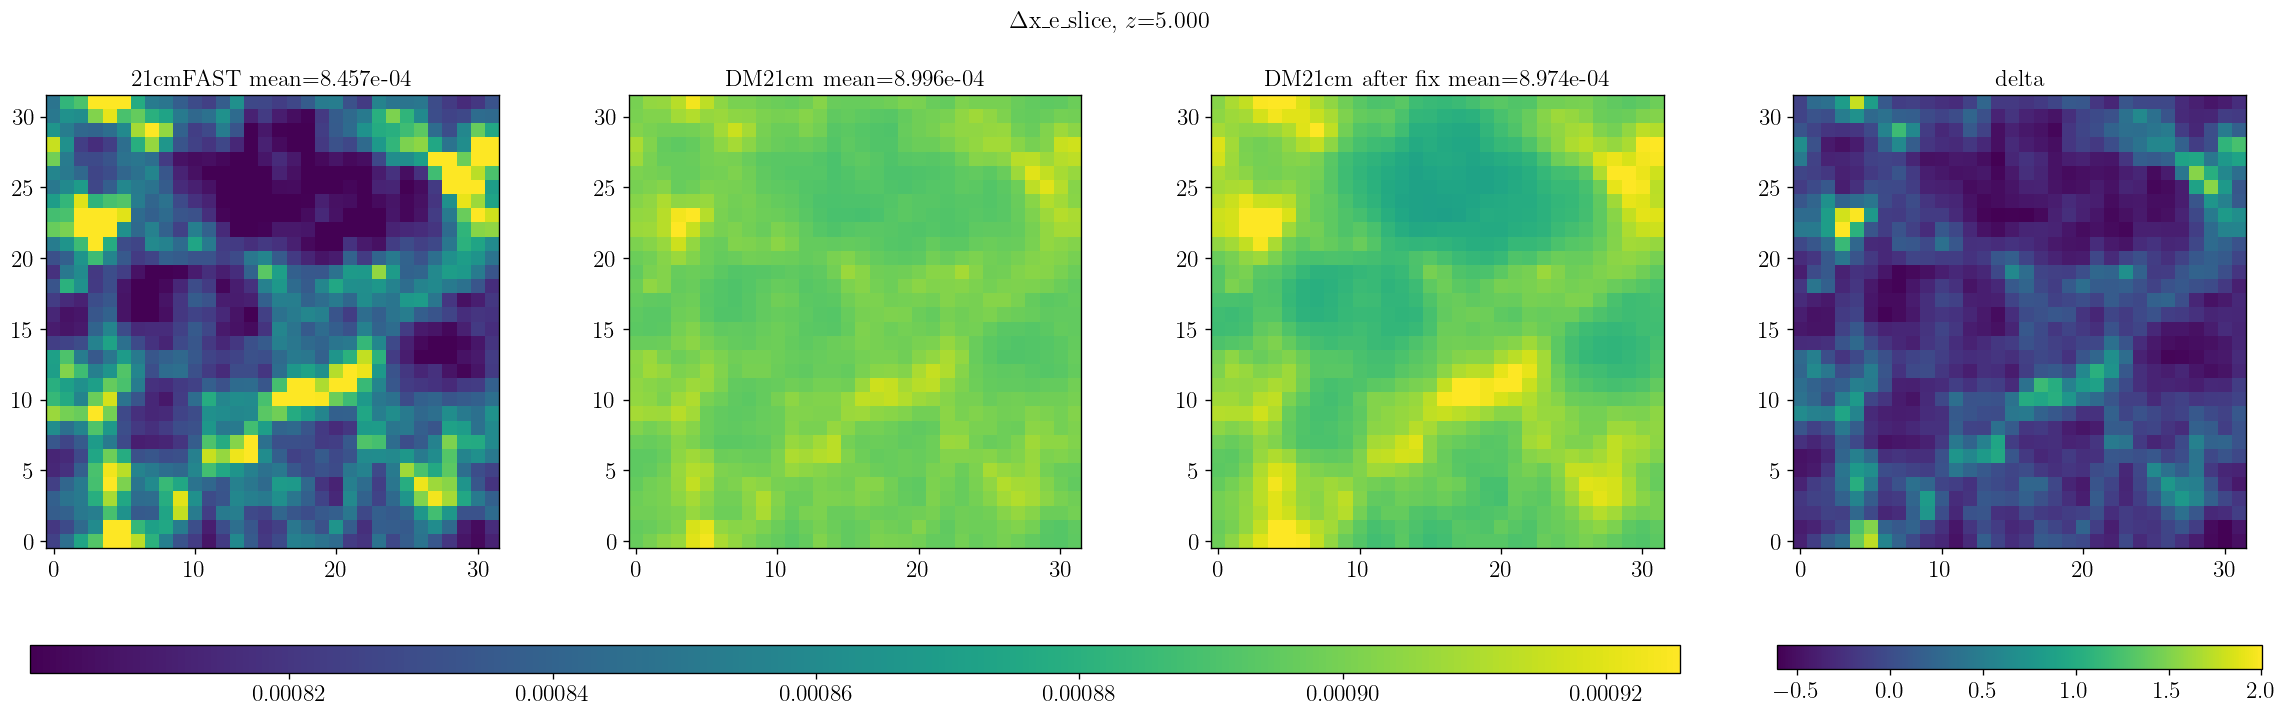

In [11]:
plot_silces_multi_runs(r_s, -1, 'x_e_slice', titles=titles, plot_delta=True, plot_log=False, plot_change_i_s=[1, 1, 1])

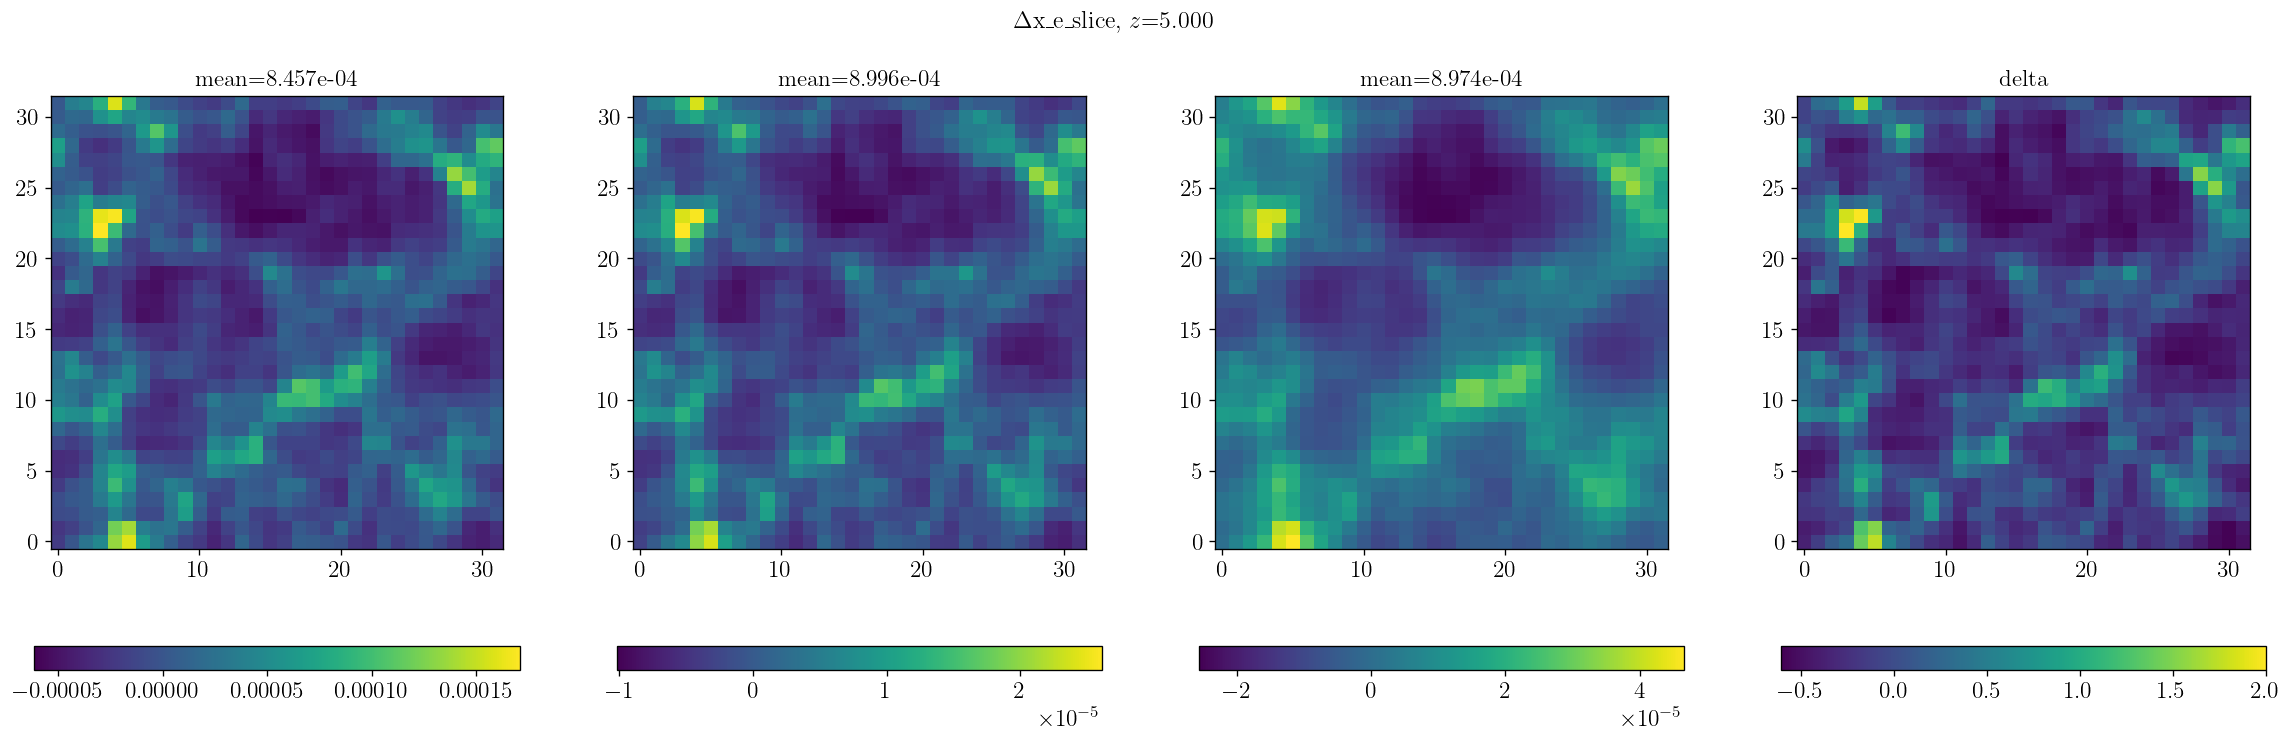

In [56]:
plot_silces_multi_runs(r_s, -1, 'x_e_slice',
                       titles=['', '', ''], plot_delta=True, plot_log=False, plot_change_i_s=[1, 1, 1], individual_cbar=True, shift_mean='+')

### 1.1 Make GIF

In [ ]:
i_array = list(range(0, 200, 10)) + list(range(195, 204))
print(i_array)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 195, 196, 197, 198, 199, 200, 201, 202, 203]


In [ ]:
for i in tqdm(i_array):
    plot_silces_multi_runs(
        r_s, [i, 10*i], 'T_k_slice',
        titles=titles, plot_delta=True, plot_log=False, plot_change_i_s=[1, 10],
        save_fn=f"plots/slices/tmp/{i}.png"#, shift_mean='+'
    )

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [02:06<00:00,  4.38s/it]


In [ ]:
from PIL import Image

def create_gif_from_filelist(file_list, output_gif_path, interval_time):
    images = [Image.open(file_path) for file_path in file_list]
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=interval_time * 1000, loop=0)

In [ ]:
flist = []
for i in i_array:
    flist.append(f"plots/slices/tmp/{i}.png")

create_gif_from_filelist(flist, "Tk.gif", 0.5)

### 1.2 Std/Mean

In [ ]:
# dc
rec_dc = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001')
dxe_dc = rec_dc['x_e_slice'][-1] - rec_dc['x_e_slice'][-2]

# pc
rec_pc = get_rec('sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001')
dxe_pc = rec_pc['x_e_slice'][-1] - rec_pc['x_e_slice'][-2]

In [ ]:
print(np.std(dxe_dc), np.mean(dxe_dc), np.std(dxe_dc)/np.mean(dxe_dc))
print(np.std(dxe_pc), np.mean(dxe_pc), np.std(dxe_pc)/np.mean(dxe_pc))

5.538167e-06 0.00089956215 0.006156514
3.630646e-05 0.0008457381 0.04292873


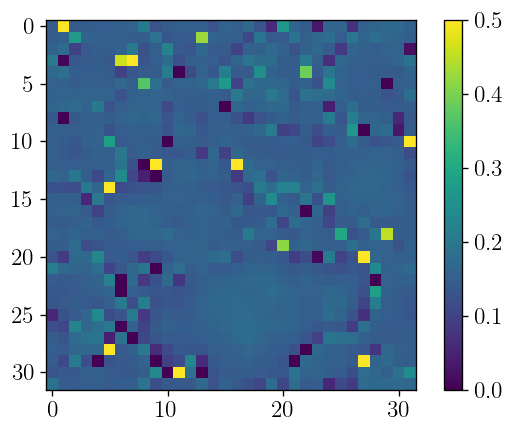

In [ ]:
z1 = dxe_dc-np.mean(dxe_dc)
z2 = dxe_pc-np.mean(dxe_pc)
plt.imshow(z1/z2, vmin=0, vmax=0.5)
plt.colorbar()

### 1.3 Global

In [12]:
sys.path.append("..")
sys.path.append(os.environ['DH_DIR'])
import dm21cm.physics as phys

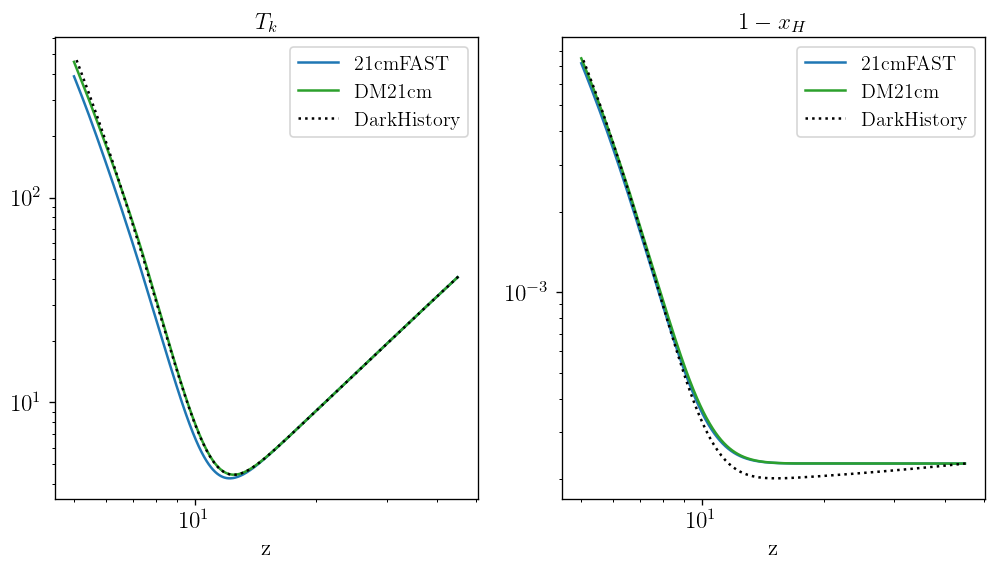

In [18]:
labels=['21cmFAST', 'DM21cm', '21cmfast', 'DM21cm']
ls_s = ['-', '-', '--', '--']
colors = ['C0', 'C2', 'C1', 'C3']

r_DH = [pickle.load(open(f"{os.environ['DM21CM_DIR']}/outputs/dh/test_soln.p", 'rb'))]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
for r, rn, ls, color in zip(r_s, labels, ls_s, colors):
    ax.plot(r['z'], r['T_k'], label=rn, ls = ls, color=color)
for r in r_DH:
    i_hi = np.argmin(np.abs(r['rs']-6))
    i_lo = np.argmin(np.abs(r['rs']-46))
    ax.plot(r['rs'][i_lo:i_hi]-1, r['Tm'][i_lo:i_hi]/phys.kB, label='DarkHistory', ls = ':', color='k')
ax.set(title='$T_k$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()

ax = axs[1]
for r, rn, ls, color in zip(r_s, labels, ls_s, colors):
    ax.plot(r['z'], r['1-x_H'], label=rn, ls = ls, color=color)
for r in r_DH:
    ax.plot(r['rs'][i_lo:i_hi]-1, r['x'][i_lo:i_hi, 0], label='DarkHistory', ls = ':', color='k')
ax.set(title='$1-x_H$', xlabel='z')
ax.set(xscale='log', yscale='log')
ax.legend()

## 2. Shell contribution

In [17]:
sys.path.append("..")
import dm21cm.physics as phys
import py21cmfast as p21c

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


### 2.1 Shell only

In [18]:
def shell_dc(rec, i, dlogR=False):

    r_out = rec['dep_tracker'][i]['R_shells']
    if dlogR:
        #r = np.append(r_out, 0.)
        r = np.insert(r_out, 0, 2*r_out[0] - r_out[1])
        #r_diff = np.log10((r[1:] + r[:-1]) / 2)
        r_diff = np.log10(r)
    else:
        #r_diff = np.append(r_out, 0.)
        r_diff = np.insert(r_out, 0, 2*r_out[0] - r_out[1])
    x = rec['1-x_H'][i]
    #norm = 2 / (3*phys.kB*(1+x)) / phys.A_per_B
    norm = 1 / 13.6 / phys.A_per_B
    dep_heat = rec['dep_tracker'][i]['dep_ion_shells'] # [eV]
    return r_out, norm*dep_heat / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

def r_vals_pc(BOX_LEN=64, HII_DIM=32, Rmax=p21c.global_params.R_XLy_MAX, n=p21c.global_params.NUM_FILTER_STEPS_FOR_Ts):
    L_FACTOR = 0.620350491
    R = L_FACTOR * BOX_LEN/HII_DIM
    R_factor = pow(Rmax/R, 1/n)
    r_vals = R * R_factor ** np.arange(n)
    return r_vals

def shell_pc(rec, i, dlogR=False, multiplier=1., **kwargs):
    
    r_out = r_vals_pc(**kwargs)
    if dlogR:
        r = np.insert(r_out, 0, 0.)
        r = np.append(r, 2*r[-1] - r[-2])
        r_diff = np.log10((r[1:] + r[:-1]) / 2)
    else:
        r_diff = np.insert(r_out, 0, 0.)
    dep_heat_K = rec['pc_shell_dep_info'][i] # [K]
    return r_out, multiplier * dep_heat_K / np.abs(np.diff(r_diff)) # [Mpc or log10Mpc], [K/Mpc or log10Mpc]

/tmp/ipykernel_465429/403784424.py:8: RuntimeWarning: divide by zero encountered in log10
  r_diff = np.log10(r)


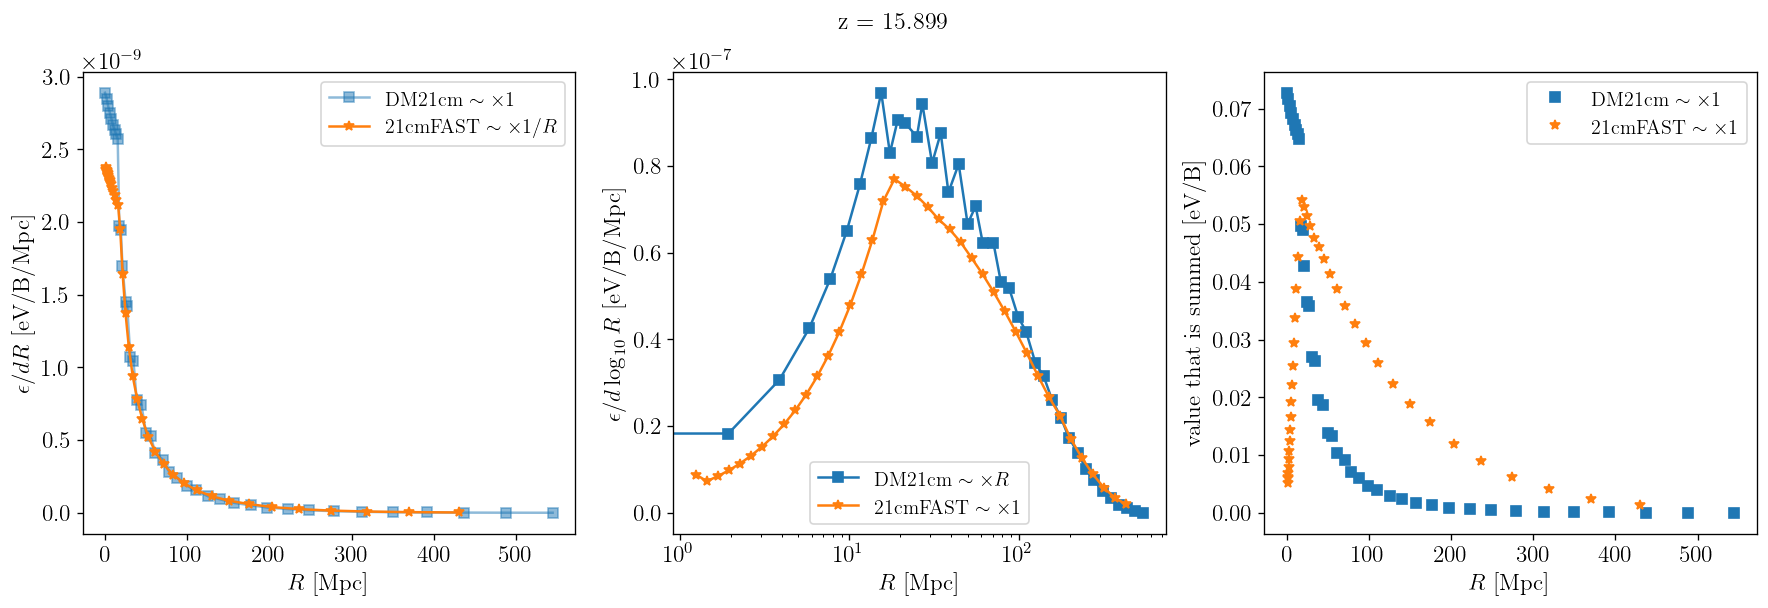

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

i = 1000

rn_s_dc = [
    'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_alldepion_uddn_01atten_ots_adashell40_zf001',
]

rn_s_pc = [
    'sf_xdecayx10_nodplus1_noxesink_nopop2_alldepion_zf001',
]

r_s_dc = [get_rec(rn) for rn in rn_s_dc]
r_s_pc = [get_rec(rn) for rn in rn_s_pc]

ax = axs[0]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=False), '-s', label=r'DM21cm $\sim\times1$', alpha=0.5)
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=False), '-*', label=r'21cmFAST $\sim\times1/R$')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/dR$ [eV/B/Mpc]')
ax.legend()

ax = axs[1]
for rec in r_s_dc:
    ax.plot(*shell_dc(rec, i, dlogR=True), '-s', label=r'DM21cm $\sim\times R$')
for rec in r_s_pc:
    ax.plot(*shell_pc(rec, i, dlogR=True), '-*', label=r'21cmFAST $\sim\times1$')
ax.set(xscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'$\epsilon/d\log_{10}R$ [eV/B/Mpc]')
ax.legend()

ax = axs[2]
for r in r_s_dc:
    r_out, val = shell_dc(r, i, dlogR=False)
    val = np.nan_to_num(val, posinf=0., neginf=0.)
    ax.plot(r_out, val/np.sum(val), 's', label=r'DM21cm $\sim\times 1$')
for r in r_s_pc:
    r_out, val = shell_pc(r, i, dlogR=True)
    val = np.nan_to_num(val, posinf=0., neginf=0.)
    ax.plot(r_out, val/np.sum(val), '*', label=r'21cmFAST $\sim\times 1$')
#ax.set(yscale='log')
ax.set(xlabel=r'$R$ [Mpc]', ylabel=r'value that is summed [eV/B]')
ax.legend()

fig.suptitle(f"z = {r_s_dc[0]['z'][i]:.3f}");

### 2.2 spec cache

In [7]:
from scipy import interpolate
from dm21cm.evolve import get_z_edges
from dm21cm.utils import load_h5_dict
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/zf01/data'

In [16]:
sfrd_tables = load_h5_dict(f"{data_dir}/sfrd_tables.h5")
z_range = sfrd_tables['z_range']
st_sfrd_table = sfrd_tables['st_sfrd_table']
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table * 10.)

In [8]:
rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots'
rec = get_rec(rn)
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))

In [18]:
def get_bath_R_eng(spec_cache, zf):
    bath_eng_s = []
    R_s = []
    z_edges = get_z_edges(45, 5, zf)[1:]
    for i_s in range(len(spec_cache.spectrum_list)):
        z = z_edges[i_s]
        bath_eng_s.append(spec_cache.spectrum_list[i_s].toteng() * ST_SFRD_Interpolator(z))
        R_s.append(phys.conformal_dx_between_z(z, z_edges[-1]))
    bath_eng_s = np.array(bath_eng_s)
    R_s = np.array(R_s)
    return R_s, bath_eng_s

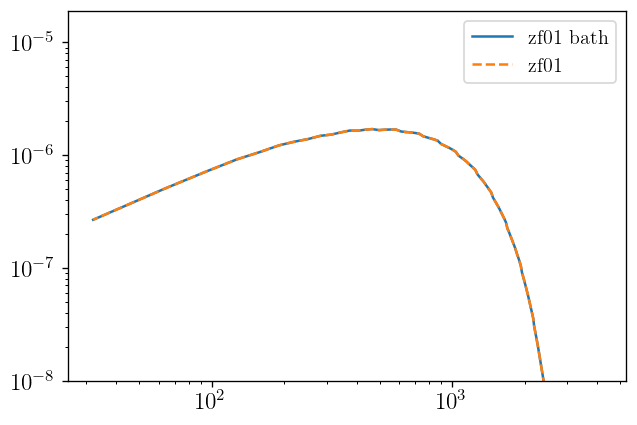

In [23]:
rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots'
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))
R_s, eng_s = get_bath_R_eng(spec_cache, 1.01)
plt.plot(R_s, R_s*eng_s, label='zf01 bath')

rn = 'sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots'
spec_cache = pickle.load(open(f"{os.environ['P21C_CACHE_DIR']}/{rn}/spec_cache.p", 'rb'))
R_s, eng_s = get_bath_R_eng(spec_cache, 1.01)
plt.plot(R_s, R_s*eng_s, label='zf01', ls='--')

plt.loglog()
plt.ylim(1e-8, None)
plt.legend()

### 2.3 shell + bath

In [21]:
rec = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots')
rec_shell = get_rec('sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots')
spec_cache_shell = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_ots/spec_cache.p', 'rb'))

In [8]:
z_edges = get_z_edges(45, 5, 1.01)[1:]

In [29]:
dtr = rec['dep_tracker'][-1]
dtr_shell = rec_shell['dep_tracker'][-1]

dep_ion_arr = []
photeng_arr = []
R_arr = []
for i_sh in range(19):
    i = 204 - len(dtr_shell['R_shells']) + i_sh
    z = z_edges[i]
    R = phys.conformal_dx_between_z(z, z_edges[-1])
    dep_ion_arr.append(dtr_shell['dep_ion_shells'][i_sh])
    photeng_arr.append(spec_cache_shell.spectrum_list[i].toteng())
    R_arr.append(R)
    print(f"i={i} z={z:.3f} R={R:.2f} R_shells={dtr_shell['R_shells'][i_sh]:.2f} dep_ion={dtr_shell['dep_ion_shells'][i_sh]:.3e} photeng={spec_cache_shell.spectrum_list[i].toteng():.3e}")
dep_ion_arr = np.array(dep_ion_arr)
photeng_arr = np.array(photeng_arr)
R_arr = np.array(R_arr)

i=185 z=6.249 R=583.77 R_shells=551.68 dep_ion=8.656e-05 photeng=2.778e-01
i=186 z=6.177 R=554.37 R_shells=522.29 dep_ion=9.091e-05 photeng=2.817e-01
i=187 z=6.106 R=524.83 R_shells=492.75 dep_ion=9.529e-05 photeng=2.857e-01
i=188 z=6.035 R=495.15 R_shells=463.06 dep_ion=1.283e-04 photeng=2.897e-01
i=189 z=5.966 R=465.32 R_shells=433.23 dep_ion=1.345e-04 photeng=3.032e-01
i=190 z=5.897 R=435.34 R_shells=403.26 dep_ion=1.414e-04 photeng=3.074e-01
i=191 z=5.829 R=405.22 R_shells=373.14 dep_ion=1.909e-04 photeng=3.117e-01
i=192 z=5.761 R=374.95 R_shells=342.87 dep_ion=1.999e-04 photeng=3.258e-01
i=193 z=5.694 R=344.53 R_shells=312.45 dep_ion=2.091e-04 photeng=3.303e-01
i=194 z=5.628 R=313.97 R_shells=281.88 dep_ion=2.812e-04 photeng=3.348e-01
i=195 z=5.562 R=283.25 R_shells=251.17 dep_ion=2.944e-04 photeng=3.494e-01
i=196 z=5.497 R=252.39 R_shells=220.30 dep_ion=3.980e-04 photeng=3.542e-01
i=197 z=5.433 R=221.37 R_shells=189.29 dep_ion=4.166e-04 photeng=3.692e-01
i=198 z=5.369 R=190.21 R_

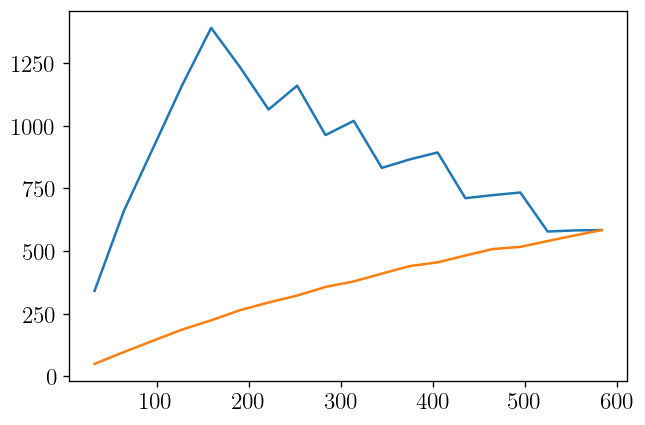

In [30]:
plt.plot(R_arr, R_arr*dep_ion_arr/dep_ion_arr[0])
plt.plot(R_arr, R_arr*photeng_arr/photeng_arr[0])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
ax = axs

dtr = rec['dep_tracker'][-1]

i_bath_start = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr'])
i_bath_end = len(z_edges) - len(dtr['R_shells'])
bath_R_s = np.array([phys.conformal_dx_between_z(z_edges[i-1], z_edges[-1]) for i in range(i_bath_start, i_bath_end)])

r = dtr['R_shells'][::-1]
v = dtr['dep_ion_shells'][::-1]
ax.plot(r[:-1], v[:-1] / np.diff(np.log10(r)), '-o')

r = bath_R_s[::-1]
v = dtr['dep_ion_bath'] * np.array(dtr['bath_toteng_arr'])/np.sum(dtr['bath_toteng_arr'])
v = v[::-1]
ax.plot(r[:-1], v[:-1] / np.diff(np.log10(r)), '-o')

ax.set(xlabel='R [Mpc]', ylabel='dep heat/dlogR [eV/s]', xscale='log')

In [17]:
spec_cache = pickle.load(open('../outputs/dm21cm/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots_zf001_spec_cache.p', 'rb'))

In [ ]:
spec_cache.spectrum_list[0].approx_attentuation_arr_repr

### 2.4 is bath overestimated?

In [37]:
from dm21cm.utils import load_h5_dict
from darkhistory.spec.spectrum import Spectrum

In [36]:
abscs = load_h5_dict(os.environ['DM21CM_DATA_DIR']+'/tf/zf01/data/abscissas.h5')

In [45]:
def init_spec():
    ilo = np.searchsorted(abscs['photE'], 500.)
    ihi = np.searchsorted(abscs['photE'], 10000.)
    dNdE = abscs['photE']**-2
    dNdE[:ilo] *= 0.
    dNdE[ihi:] *= 0.
    s = Spectrum(abscs['photE'], dNdE, spec_type='dNdE', rs=1+45.)
    s.switch_spec_type('N')
    return s

def cont_redshift(s, z_edges, i):
    for z in z_edges[:i+1]:
        s.redshift(z)

def bath_overestimate(rec, i_z_view, i_bath):
    dtr = rec['dep_tracker'][i_z_view]
    i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_bath
    scont = init_spec()
    sinst = init_spec()
    cont_redshift(scont, z_edges, i_z)
    sinst.redshift(z_edges[i_z])

    ilo = np.searchsorted(abscs['photE'], 500.)
    scont.N[:ilo] *= 0.
    sinst.N[:ilo] *= 0.

    s = spec_cache.spectrum_list[i_bath]
    atten_arr = s.approx_attenuation_arr
    cont_eng = np.dot(s.eng, scont.N*atten_arr)
    inst_eng = np.dot(s.eng, sinst.N*atten_arr)
    return inst_eng/cont_eng

In [60]:
spec_cache01 = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/sf_xdecayx10_nodplus1_dc_noLX_noxesink_nopop2_uddn_01atten_bath_ots/spec_cache.p', 'rb'))

In [54]:
bath_eng_naive = []
R_s = []
i_z_view = -1
dtr = rec['dep_tracker'][i_z_view]

for i_bath_rel in range(len(dtr['bath_toteng_arr'])):
    i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_bath_rel
    bath_eng_naive.append(spec_cache.spectrum_list[i_z].toteng())
    R_s.append(phys.conformal_dx_between_z(z_edges[i_z], z_edges[-1]))
bath_eng_naive = np.array(bath_eng_naive)
R_s = np.array(R_s)

In [ ]:
i_z_view = -1
dtr = rec['dep_tracker'][i_z_view]
for i_bath_rel in range(len(dtr['bath_toteng_arr'])):
    print(i_bath_rel, bath_overestimate(rec, i_z_view, i_bath_rel))

In [ ]:
i_z_view = -1
i_sl = 0

dtr = rec['dep_tracker'][i_z_view]
i_z = len(z_edges) - len(dtr['R_shells']) - len(dtr['bath_toteng_arr']) + i_sl
scont = init_spec()
sinst = init_spec()
cont_redshift(scont, z_edges, i_z)
sinst.redshift(z_edges[i_z])

s = spec_cache.spectrum_list[i_sl]
atten_arr = s.approx_attenuation_arr

plt.plot(s.eng, scont.N, color='C0', ls='--')
plt.plot(s.eng, scont.N*atten_arr, color='C0')
plt.plot(s.eng, sinst.N, color='C1', ls='--')
plt.plot(s.eng, sinst.N*atten_arr, color='C1')
plt.loglog()
plt.xlim(300, 30000)
plt.ylim(1e-10, 1e-4)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]

s = spec_cache.spectrum_list[0]
ax.plot(s.eng, s.spectrum.N)
ax.plot(s.eng, s.N)
ax.set(xlim=(300, 30000), xscale='log', yscale='log', ylim=(1e-10, None))

ax = axs[1]
ax.plot(s.eng, s.approx_attenuation_arr)
ax.set(xlim=(300, 30000), xscale='log')